In [1]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
from scipy.special import softmax
import pickle as pkl
import gzip

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context(True)
            context = context.reshape( (1, -1) )
            outcome = 0 if distribution[0]<0.5 else 1
            # distribution = np.array([1-outcome, outcome])
            # print(distribution_init, distribution, outcome, )
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )

            print('t', t, 'action', action, 'outcome', outcome,  )
            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

        return history, cumRegret, global_loss, global_losses

In [3]:
import numpy as np
import random
import torch
import cbpside
import rand_cbpside
import synthetic_data
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint2
import rand_neural_lin_cbpside_disjoint3
import randneuralcbp_AT
import games
import explore_commit2
import STAP_Helmbolt_AT
import cesa_bianchi
import random_algo

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

H = 200
horizon = 20000

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
# context_generator = synthetic_data.QuinticContexts_imbalanced(  )
context_generator.set_b(0)
context_generator.normalization()

game = games.apple_tasting( )

alg = random_algo.Random(game, horizon)
alg.reset()

# alg = STAP_Helmbolt_AT.STAP_Helmbolt(game, 20, H, 'cuda:0')

# lbd_neural = 0
# lbd_reg = 1
# sigma = 1
# K = 10
# epsilon = 10e-7
# alg = randneuralcbp_AT.CBPside( game, 1.01, [0], lbd_neural, lbd_reg, sigma, K, epsilon, 20, H,  'cuda:0')
# alg.reset(context_generator.d)

evaluator = Evaluate()

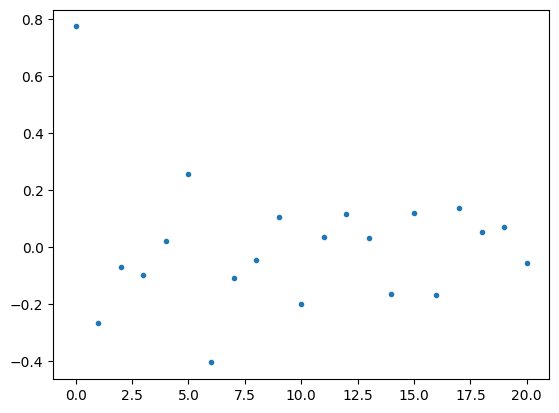

In [18]:
plt.plot(alg.contexts['feats'], '.')
plt.plot(alg.contexts['weights'], '.')
np.mean( alg.contexts['feats'], 0)

In [4]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

t 0 action 1 outcome 1
t 1 action 1 outcome 1
t 2 action 0 outcome 0
t 3 action 0 outcome 1
t 4 action 1 outcome 1
t 5 action 0 outcome 0
t 6 action 1 outcome 1
t 7 action 1 outcome 1
t 8 action 1 outcome 0
t 9 action 1 outcome 0
t 10 action 1 outcome 0
t 11 action 1 outcome 0
t 12 action 0 outcome 1
t 13 action 1 outcome 0
t 14 action 1 outcome 0
t 15 action 0 outcome 1
t 16 action 0 outcome 1
t 17 action 1 outcome 1
t 18 action 1 outcome 1
t 19 action 1 outcome 0
t 20 action 0 outcome 1
t 21 action 1 outcome 0
t 22 action 1 outcome 0
t 23 action 0 outcome 0
t 24 action 1 outcome 1
t 25 action 0 outcome 0
t 26 action 1 outcome 1
t 27 action 0 outcome 1
t 28 action 1 outcome 0
t 29 action 1 outcome 0
t 30 action 0 outcome 0
t 31 action 1 outcome 0
t 32 action 1 outcome 1
t 33 action 1 outcome 1
t 34 action 0 outcome 0
t 35 action 0 outcome 0
t 36 action 1 outcome 0
t 37 action 1 outcome 1
t 38 action 0 outcome 1
t 39 action 1 outcome 1
t 40 action 1 outcome 1
t 41 action 1 outcome 0
t 

In [5]:
result = [history, cumRegret]

with gzip.open( './results/{}_{}_{}.pkl.gz'.format(alg.name, budget, horizon) ,'wb') as f:
    pkl.dump(result,f)

In [5]:
horizon = 20000

with gzip.open( './results/AT_{}_{}_20000.pkl.gz'.format('random',  horizon) ,'rb') as f:
    result1 = pkl.load(f)

with gzip.open( './results/AT_{}_{}_20000.pkl.gz'.format('helmbolt',  horizon) ,'rb') as f:
    result2 = pkl.load(f)

with gzip.open( './results/AT_{}_{}_20000.pkl.gz'.format('randneuralcbp',  horizon) ,'rb') as f:
    result3 = pkl.load(f)

In [5]:
train_hist = [sublist for sublist in history if sublist['over_budget'] is False]
depl_hist = [sublist for sublist in history if sublist['over_budget'] is True]

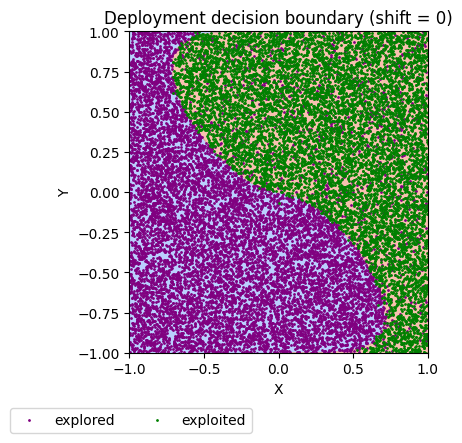

In [6]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

# contexts = np.array( [ context_generator.denormalize(i[5]) for i in train_hist ] ).squeeze(1) 
contexts = np.array( [ context_generator.denormalize(i['context']) for i in train_hist ] ).squeeze(1) 

action1 = [ i['monitor_action'] if i['monitor_action']==0 else np.nan for i in train_hist ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i['monitor_action'] if i['monitor_action']==1 else np.nan for i in train_hist ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', markersize = 2, label = 'predicted as class 1')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', markersize = 2, label = 'predicted as class 2')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'purple', markersize = 2, label = 'explored')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', markersize = 2, label = 'exploited')

plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/ETC_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/{}_4_{}.png'.format(alg.name,b), dpi=380, bbox_inches='tight')

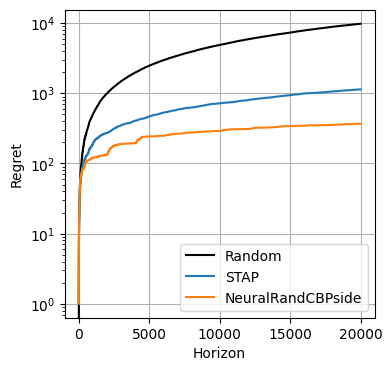

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(result1[1]), label = 'Random', color = 'black')
plt.plot(np.cumsum(result2[1]), label = 'STAP')
plt.plot(np.cumsum(result3[1]), label = 'NeuralRandCBPside')
plt.legend()
plt.yscale('log')
plt.grid()
plt.ylabel('Regret')
plt.xlabel('Horizon')
plt.savefig('./figures/AT_results.png', dpi=380, bbox_inches='tight')

# plt.ylim((0,1000))
# plt.xlim((0,2000))
# plt.savefig('./figures/ETC_regret3.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret4.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/{}_regret4.png'.format(alg.name), dpi=380, bbox_inches='tight')

Text(0, 0.5, 'Loss')

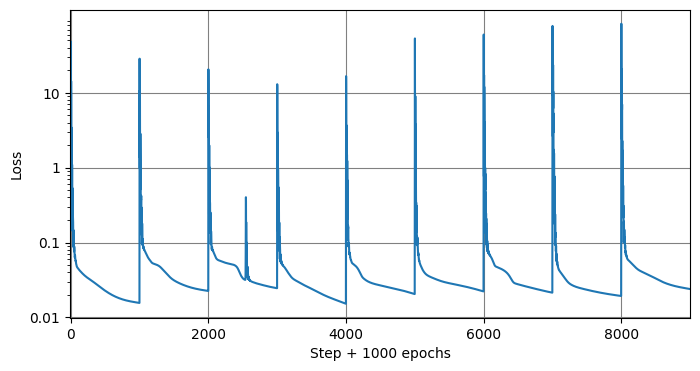

In [8]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1500

custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


[0.15563217720669367, 0.1521894269510349, 0.14231141863788724, 0.12725216842632045, 0.10880799627607346, 0.08896652168442347, 0.06956048275578135, 0.0520078308933482, 0.03718305524595188, 0.025420938520946002, 0.016619129280754274, 0.010389511535224289, 0.0062108661578205195, 0.0035504171992334402, 0.00194078212903777, 0.0010144820280326265, 0.0005070865698274714, 0.00024237623588767749, 0.00011078172981294182, 4.841906796273143e-05, 2.0236475979154237e-05, 8.087671887470322e-06, 3.0908813873488927e-06, 1.1295652734210218e-06, 3.947394236392123e-07, 1.3191064701421465e-07, 4.2152115529155345e-08, 1.2880391946086604e-08, 3.763647655231552e-09, 1.0516204348970242e-09, 2.8098248679023805e-10, 7.179094407494883e-11, 1.754002688082076e-11, 4.097896848148577e-12, 9.155076280840319e-13, 1.9558389455115003e-13, 3.9955299433575266e-14, 7.80523291188801e-15, 1.4580335655830855e-15, 2.604469970640551e-16, 4.448784451788597e-17, 7.26663843375154e-18, 1.135000143113072e-18, 1.6952293331193547e-19, 

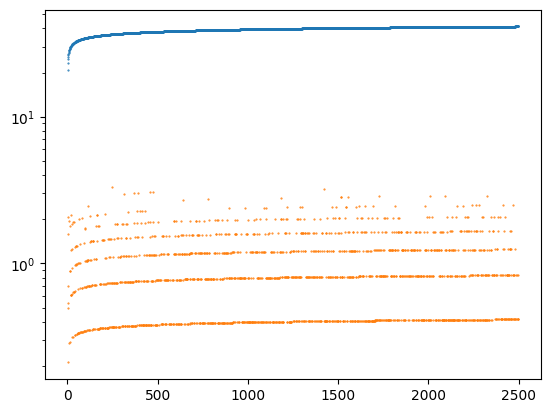

In [46]:


def obtain_probability(t , factor):

    sigma = 1
    K = 100
    epsilon = 10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
    print(p_m)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 20
    N = 3
    H = 50
    lbd_reg = 1
    # factor = sigma_i * (  np.sqrt( d * np.log(t) + 2 * np.log(1/t**2)  ) + lbd_reg * sigma_i )
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)
plt.yscale('log')


(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

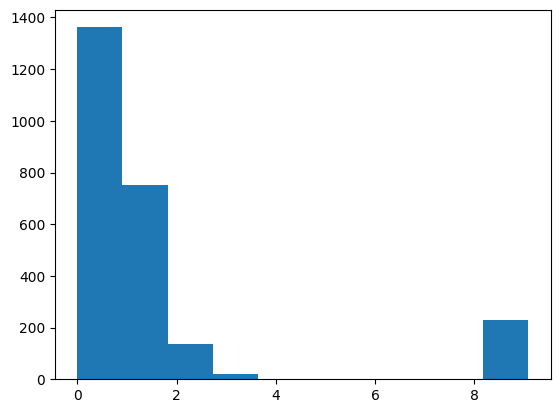

In [67]:
plt.hist(rand, bins = 10)